## Import packages

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import xesmf as xe
import numpy as np
import geopandas as gpd
import shapely.geometry as geom
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import cartopy.crs as ccrs
from scipy.stats import mannwhitneyu

## Load data 

In [2]:
datapath = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf_new'
variable = 'air_temperature_1p5m'

experiment1 = 'drysoil_d0198_RAL3P2_albedo_bare_' 
allvar = xr.open_dataset(f'{datapath}/{variable}/{experiment1}{variable}.nc')['air_temperature']

experiment2 = 'control_d0198_RAL3P2_' 
control = xr.open_dataset(f'{datapath}/{variable}/{experiment2}{variable}.nc')['air_temperature']

experiment3 = 'control_d0198_RAL3P2_albedo_bare_'
albedo_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment3}{variable}.nc')['air_temperature']

experiment4 = 'control_d0198_RAL3P2_albedo_'
albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment4}{variable}.nc')['air_temperature']

experiment5 = 'control_d0198_RAL3P2_bare_'
bare = xr.open_dataset(f'{datapath}/{variable}/{experiment5}{variable}.nc')['air_temperature']

experiment6 = 'drysoil_d0198_RAL3P2_albedo_'
SM_albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment6}{variable}.nc')['air_temperature']

experiment7 = 'drysoil_d0198_RAL3P2_bare_'
SM_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment7}{variable}.nc')['air_temperature']

experiment8 = 'drysoil_d0198_RAL3P2_'
SM = xr.open_dataset(f'{datapath}/{variable}/{experiment8}{variable}.nc')['air_temperature']


In [3]:
fires = gpd.read_file('/g/data/ng72/as9583/merged_fires.gpkg')
variable2 = 'surface_altitude'
sa1 = xr.open_dataset(f'{datapath}/{variable2}/{experiment1}{variable2}.nc')[variable2].isel(time=0)

## Land only, sum to daily totals

In [4]:
#clip to land only
variable3 = 'land_sea_mask'
landmask = xr.open_dataset(f'{datapath}/{variable3}/{experiment1}{variable3}.nc')["land_binary_mask"].isel(time=0)
allvar = allvar.where(landmask == 1)
control = control.where(landmask == 1)
albedo_bare = albedo_bare.where(landmask == 1)
albedo = albedo.where(landmask == 1)
bare = bare.where(landmask == 1)
SM_albedo = SM_albedo.where(landmask == 1)
SM_bare = SM_bare.where(landmask == 1)
SM = SM.where(landmask == 1)

In [5]:
experiments = {
    "All Variables": allvar,
    "Control": control,
    "Albedo + Bare": albedo_bare,
    "Albedo": albedo,
    "Bare": bare,
    "SM + Albedo": SM_albedo,
    "SM + Bare": SM_bare,
    "SM": SM
}


for name in experiments:
    experiments[name] = experiments[name].assign_coords(time=experiments[name].time + pd.Timedelta(hours=10))
    experiments[name] = experiments[name].where(landmask == 1)

In [6]:
#clip to fires
fires = fires.to_crs("EPSG:7844")

clipped = {}

for name, da in experiments.items():
    da = da.rio.write_crs("EPSG:7844")
    
    clipped_da = da.rio.clip(fires.geometry, fires.crs, drop=True, invert=False)
    
    clipped[name] = clipped_da

In [7]:
allvarf = clipped['All Variables']
controlf =clipped['Control']
albedo_baref =clipped['Albedo + Bare']
albedof =clipped['Albedo']
baref =clipped['Bare']
SM_albedof =clipped['SM + Albedo']
SM_baref=clipped['SM + Bare']
SMf =clipped['SM']

In [9]:
experimentsf = {
    "All Variables": allvarf,
    "Control": controlf,
    "Albedo + Bare": albedo_baref,
    "Albedo": albedof,
    "Bare": baref,
    "SM + Albedo": SM_albedof,
    "SM + Bare": SM_baref,
    "SM": SMf
}
for key in experimentsf:
    experimentsf[key] = experimentsf[key].where(landmask == 1)

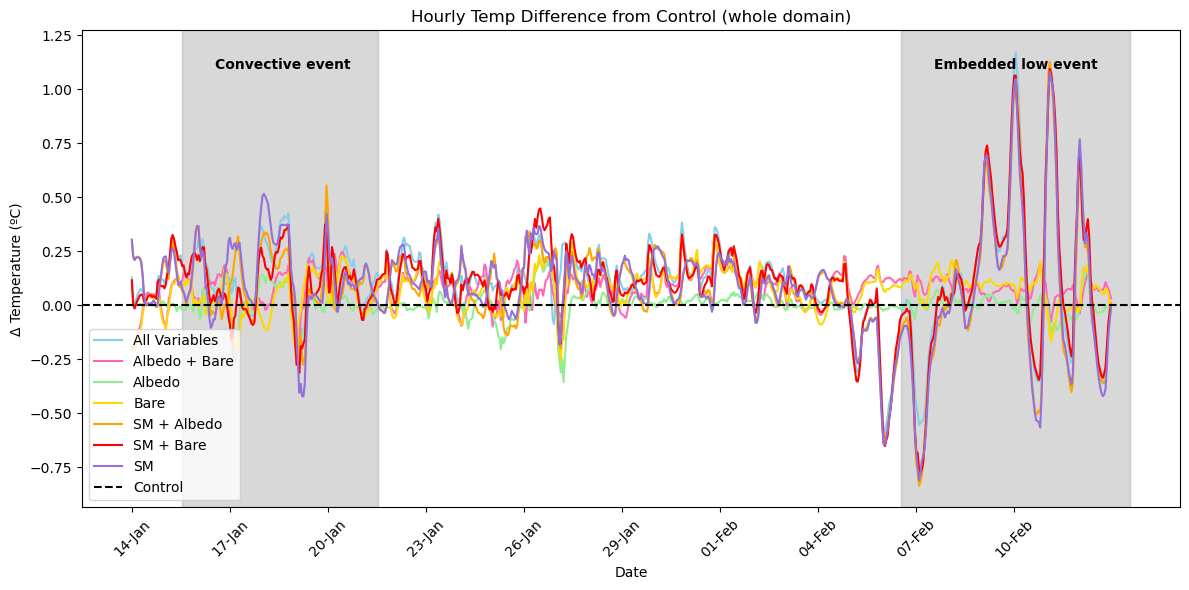

In [10]:
ref_name = "Control"
ref = experiments[ref_name]

# diff from control
diff_hourly = {}
for name, da in experiments.items():
    if name != ref_name:
        diff_hourly[name] = (da - ref) 

colors = ["skyblue", "hotpink", "lightgreen", "gold", 
          "orange", "red", "mediumpurple", "pink"]

plt.figure(figsize=(12,6))

for i, (name, da) in enumerate(diff_hourly.items()):
    time_series = da.mean(dim=["latitude","longitude"], skipna=True)
    dates_aest = pd.to_datetime(time_series.time.values)
    # + pd.Timedelta(hours=10)  # shift to AEST
    plt.plot(dates_aest, time_series, label=name, color=colors[i % len(colors)])

# ECL event
plt.axvspan(pd.to_datetime("2020-02-07 00:00"),
            # + pd.Timedelta(hours=10),
            pd.to_datetime("2020-02-13 23:59"),
            # + pd.Timedelta(hours=10),
            color="grey", alpha=0.3)
plt.text(pd.to_datetime("2020-02-08 00:00"),
         # + pd.Timedelta(hours=10),
         plt.ylim()[1]*0.9, "Embedded low event", va="top", ha="left", fontsize=10, color="black", weight='demi')

#convective
plt.axvspan(pd.to_datetime("2020-01-16 00:00"),
            # + pd.Timedelta(hours=10),
            pd.to_datetime("2020-01-21 23:59"),
            # + pd.Timedelta(hours=10),
            color="grey", alpha=0.3)
plt.text(pd.to_datetime("2020-01-16 23:59"),
         # + pd.Timedelta(hours=10),
         plt.ylim()[1]*0.9, "Convective event", va="top", ha="left", fontsize=10, color="black", weight='demi')

# baseline (control)
plt.axhline(0, color='k', linestyle='--')
control_handle = mlines.Line2D([], [], color='k', linestyle='--', label="Control")

plt.ylabel("Δ Temperature (ºC)")
plt.xlabel("Date")
plt.title(f"Hourly Temp Difference from {ref_name} (whole domain)")
plt.legend(handles=[*plt.gca().get_legend_handles_labels()[0], control_handle], loc="lower left")

# format x-axis
plt.xticks(
    ticks=dates_aest[::max(1, len(dates_aest)//10)],
    labels=[d.strftime("%d-%b") for d in dates_aest[::max(1, len(dates_aest)//10)]],
    rotation=45
)

plt.tight_layout()
plt.show()


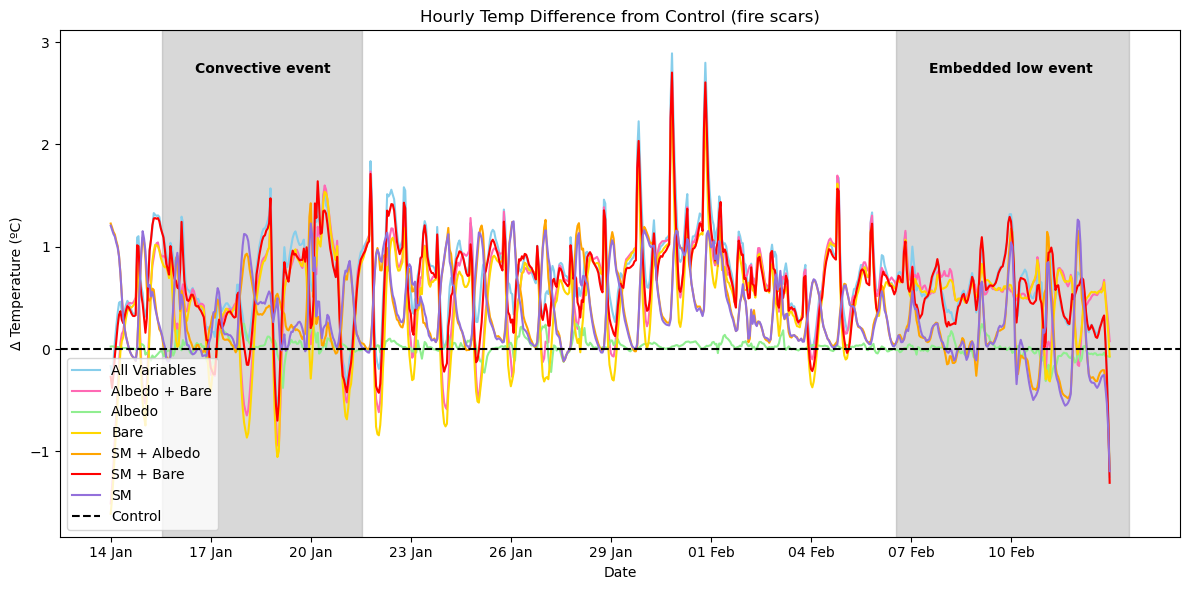

In [11]:
ref_name = "Control"
ref = experimentsf[ref_name]

#diff from control
diff_hourly = {}
for name, da in experimentsf.items():
    if name != ref_name:
        diff_hourly[name] = da - ref

colors = ["skyblue", "hotpink", "lightgreen", "gold", 
          "orange", "red", "mediumpurple", "pink"]

plt.figure(figsize=(12,6))

for i, (name, da) in enumerate(diff_hourly.items()):
    time_series = da.mean(dim=["latitude","longitude"], skipna=True)
    dates_aest = pd.to_datetime(time_series.time.values)
    # + pd.Timedelta(hours=10) #shift to AEST
    plt.plot(dates_aest, time_series, label=name, color=colors[i % len(colors)])

#ECL event
plt.axvspan(pd.to_datetime("2020-02-07 00:00"),
            # + pd.Timedelta(hours=10),
            pd.to_datetime("2020-02-13 23:59"),
            # + pd.Timedelta(hours=10),
            color="grey", alpha=0.3)
plt.text(pd.to_datetime("2020-02-08 00:00"),
         # + pd.Timedelta(hours=10),
         plt.ylim()[1]*0.9, "Embedded low event", va="top", ha="left", fontsize=10, color="black", weight='demi')

#convective
plt.axvspan(pd.to_datetime("2020-01-16 00:00"),
            # + pd.Timedelta(hours=10),
            pd.to_datetime("2020-01-21 23:59"),
            # + pd.Timedelta(hours=10),
            color="grey", alpha=0.3)
plt.text(pd.to_datetime("2020-01-16 23:59"),
         # + pd.Timedelta(hours=10),
         plt.ylim()[1]*0.9, "Convective event", va="top", ha="left", fontsize=10, color="black", weight='demi')

#baseline control
plt.axhline(0, color='k', linestyle='--')
control_handle = mlines.Line2D([], [], color='k', linestyle='--', label="Control")

plt.ylabel("Δ Temperature (ºC)")
plt.xlabel("Date")
plt.title(f"Hourly Temp Difference from {ref_name} (fire scars)")
plt.legend(handles=[*plt.gca().get_legend_handles_labels()[0], control_handle], loc="lower left")

#format x axis
plt.xticks(
    ticks=dates_aest[::max(1, len(dates_aest)//10)],
    labels=[d.strftime("%d %b") for d in dates_aest[::max(1, len(dates_aest)//10)]],
    rotation=0
)

plt.tight_layout()
# plt.savefig('/g/data/ng72/as9583/new_analysis/figures/hourly_precip_diff_timeseries.png')
plt.show()



# SPATIAL

## Difference plots, entire period

In [12]:
target_time = "2020-01-14T12:00"  # <-- your target timestep

instant = {}
for name, da in experiments.items():
    da = da.sel(time=target_time)  # select that exact time instead of averaging
    instant[name] = da.where(landmask == 1)


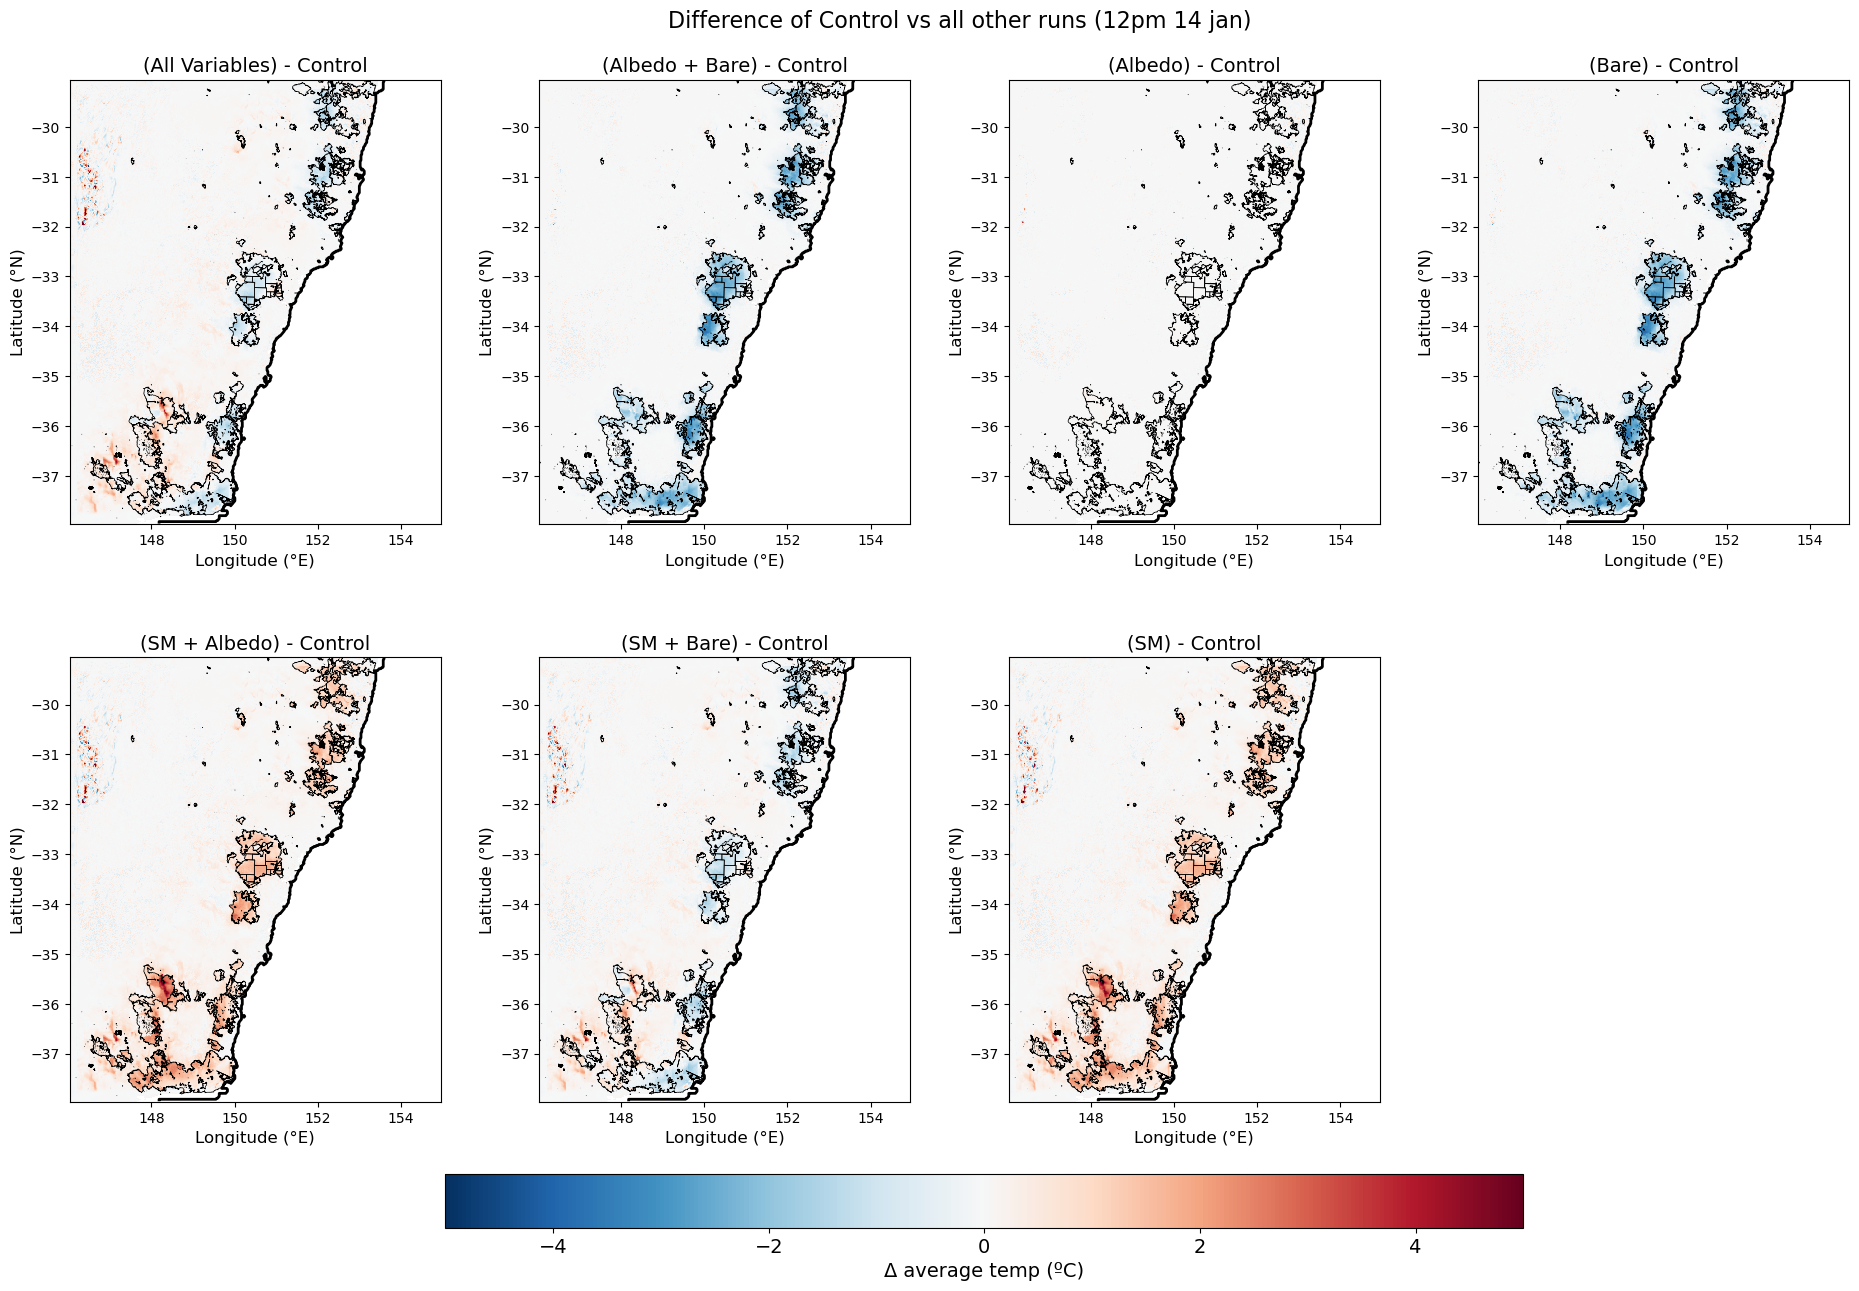

In [13]:
for key in instant:
    instant[key] = instant[key].where(landmask == 1)

names = list(instant.keys())
ref_index = 1 #index of ref, 0 = allvar
ref_name = names[ref_index]

levels = np.arange(-3,3, 0.5)
ncols = 4
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 14))
axes = axes.flatten()

plot_idx = 0
cbar_ax = None 

for i, name in enumerate(names):
    if i == ref_index:
        continue  #skip reference 

    diff = instant[name] - instant[ref_name] 
    ax = axes[plot_idx]

    mesh = diff.plot(
        ax=ax,
        cmap="RdBu_r",
        center=0,
        # levels=levels,
        vmin=-5, vmax =5,
        extend="both",
        add_colorbar=False
    )

    if plot_idx == 0:
        cbar_ax = mesh 
    sa1.plot.contour(ax=ax, levels=[0], colors="black", linewidths=2, add_colorbar=False)
    gpd.GeoSeries(fires.boundary).plot(ax=ax, edgecolor="black", linewidth=0.5)

    ax.set_title(f"({name}) - {ref_name}", fontsize = 14)
    ax.set_xlabel("Longitude (°E)", fontsize=12)
    ax.set_ylabel("Latitude (°N)", fontsize=12)

    plot_idx += 1

#remove unused axis
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])

#shared colorbar along the bottom
cbar = fig.colorbar(
    cbar_ax, ax=axes[:plot_idx],
    orientation='horizontal',
    fraction=0.05,
    pad=0.02      
    # label="Cumulative rainfall difference (mm)"
)

# Adjust tick label font size
cbar.ax.tick_params(labelsize=14)  # or your preferred size

# Adjust label font size
cbar.set_label("Δ average temp (ºC)", fontsize=14)

#adjust spacing
fig.subplots_adjust(left=0.05, right=0.95, top=0.93, bottom=0.20, hspace=0.3, wspace=0.2)

fig.suptitle(f"Difference of {ref_name} vs all other runs (12pm 14 jan)", fontsize=16)
# plt.savefig('/g/data/ng72/as9583/new_analysis/figures/cumulative_difference.png')
plt.show()


In [14]:
mean = {}

for name, da in experiments.items():
    da = da.mean(dim='time', skipna=True)
    mean[name] = da


In [ ]:
for key in mean:
    mean[key] = mean[key].where(landmask == 1)

names = list(mean.keys())
ref_index = 1 #index of ref, 0 = allvar
ref_name = names[ref_index]

levels = np.arange(-3,3, 0.5)
ncols = 4
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 14))
axes = axes.flatten()

plot_idx = 0
cbar_ax = None 

for i, name in enumerate(names):
    if i == ref_index:
        continue  #skip reference 

    diff = mean[name] - mean[ref_name] 
    ax = axes[plot_idx]

    mesh = diff.plot(
        ax=ax,
        cmap="RdBu_r",
        center=0,
        # levels=levels,
        vmin = -2, vmax=2,
        extend="both",
        add_colorbar=False
    )

    if plot_idx == 0:
        cbar_ax = mesh 
    sa1.plot.contour(ax=ax, levels=[0], colors="black", linewidths=2, add_colorbar=False)
    gpd.GeoSeries(fires.boundary).plot(ax=ax, edgecolor="black", linewidth=0.5)

    ax.set_title(f"({name}) - {ref_name}", fontsize = 16, fontweight = 'bold')
    ax.set_xlabel("Longitude (°E)", fontsize=14)
    ax.set_ylabel("Latitude (°N)", fontsize=14)

    plot_idx += 1

#remove unused axis
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])

#shared colorbar along the bottom
cbar = fig.colorbar(
    cbar_ax, ax=axes[:plot_idx],
    orientation='horizontal',
    fraction=0.05,
    pad=0.02      
    # label="Cumulative rainfall difference (mm)"
)

# Adjust tick label font size
cbar.ax.tick_params(labelsize=16)  # or your preferred size

# Adjust label font size
cbar.set_label("Δ Mean temperature (ºC)", fontsize=16)

#adjust spacing
fig.subplots_adjust(left=0.05, right=0.95, top=0.93, bottom=0.20, hspace=0.3, wspace=0.2)

fig.suptitle(f"Difference of {ref_name} vs all other runs (full period)", fontsize=16)
# plt.savefig('/g/data/ng72/as9583/new_analysis/figures/mean_temp_difference.png')
plt.show()
